<a href="https://colab.research.google.com/github/TheBlock98/Thesis/blob/main/HybridModelCNNLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np

config = {
    "data": {
        "window_size": 200,
        "train_split_size": 0.70,
        "test_split_size": 0.20,
        "validation_split_size":
        0.10,  # in un secondo momento faremo la cross-validation
    },
    "model": {
        "input_size": 61,
        "num_lstm_layers": 1,
        "lstm_size": 64,
        "dropout": 0,
        "num_class": 1,
        "model_path": "Model/modelLSTMV0.pth",
        "model_name": "LSTMV0.txt",
        "save_model": True,
    },
    "training": {
        "device": "cuda",  # "cuda" or "cpu"
        "batch_size": 64,
        "num_epochs": 100,
        "learning_rate": 3e-4,
        "weight_decay": 0.001,
        "momentum": 0.9,
        "loss_function": nn.MSELoss(),
        "optimizer": torch.optim.Adam,
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "scheduler_patience": 3,
        "scheduler_factor": 0.5,
        "scheduler_min_lr": 1e-6,
        "early_stopping": True,
        "early_stopping_patience": 4,
        "forget_bias": 0.1,
    },
}
dataSet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRNormalized.csv")
hlc3 = dataSet['hlc3']
dataSet.drop(labels=['hlc3'], axis=1, inplace=True)
dataSet.insert(0, 'hlc3', hlc3)

# Dataloading (sliding windows)
config["model"]["input_size"] = dataSet.shape[
    1]  # with 1 have number of features

# otherwise we can try in this manner y will be with this shape (30009, 200, 61)

# Create sequences and labels for training data


# Create sequences and labels for training data
def sliding_windows2(df, windowSize):
  x = []
  y = []
  # Loop runs one less time to avoid index out of bounds
  for i in range(len(df) - windowSize):
    # Convert DataFrame slice to values and append to x
    _x = df.iloc[i:i + windowSize].values
    # Get the first element `'hlc3'` of the next block
    _y = df.iloc[i + windowSize][0]
    y.append(_y)
    x.append(_x)
  return np.array(x), np.array(y)


train_size = int(len(dataSet) * config["data"]["train_split_size"])
val_size = int(len(dataSet) * config["data"]["validation_split_size"])
test_size = len(dataSet) - train_size - val_size  # Remaining data for testing

trDataSet = dataSet.iloc[:train_size]
valDataSet = dataSet.iloc[train_size:train_size+val_size]
testDataSet = dataSet.iloc[train_size+val_size:]


trX , trY = sliding_windows2(trDataSet, config["data"]["window_size"])
valX , valY = sliding_windows2(valDataSet, config["data"]["window_size"])
testX , testY = sliding_windows2(testDataSet, config["data"]["window_size"])



# Convert from numpy arrays to torch tensors
trX_tensor = torch.tensor(trX, dtype=torch.float32)
trY_tensor = torch.tensor(trY, dtype=torch.float32).unsqueeze(1)
valX_tensor = torch.tensor(valX, dtype=torch.float32)
valY_tensor = torch.tensor(valY, dtype=torch.float32).unsqueeze(1)
testX_tensor = torch.tensor(testX, dtype=torch.float32)
testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

# fai un check fr
print(trX.shape , trY.shape)
print("trx value \n")
print(trX[:3])

print("\n try value")
print(trY[:3])

# Define the PyTorch Dataset class

# Define the PyTorch Dataset class
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super(). __init__()
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]


# Create Dataset instances
train_dataset = TimeSeriesDataset(trX_tensor, trY_tensor)
val_dataset = TimeSeriesDataset(valX_tensor, valY_tensor)
test_dataset = TimeSeriesDataset(testX_tensor, testY_tensor)

# Create DataLoader instances
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config["training"]["batch_size"],
                          shuffle=False)
""" bisogna fare una prova con shffle = True e False Tuttavia, per i dati strutturati come "finestre scorrevoli" (sliding windows), dove ogni campione è indipendente e contiene le informazioni temporali necessarie nel contesto della finestra stessa, l'operazione di shuffle potrebbe non essere dannosa. In questo caso, ogni finestra agisce come un campione indipendente e il modello impara da queste finestre piuttosto che dalla sequenza complessiva """
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config["training"]["batch_size"],
                        shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=config["training"]["batch_size"],
                         shuffle=False)


class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout, num_class,
               sequence_length):
    super().__init__()

    # Definizione del modello usando nn.Sequential
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ELU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False),
    )
    self.endLinearLayer = nn.Linear(sequence_length, num_class)

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    return x


HybridModelV1 = CNNLSTMModel(
    input_size=61,
    num_lstm_layers=config["model"]["num_lstm_layers"],
    dropout=config["model"]["dropout"],
    num_class=1,
    sequence_length=config["data"]["window_size"])
print(HybridModelV1)
HybridModelV1.to(config["training"]["device"])


train_hist = []
val_hist = []
test_hist = []
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(HybridModelV1.parameters(),
                             lr=config["training"]["learning_rate"])

scheduler = config["training"]["scheduler"](
    optimizer,
    patience=config["training"]["scheduler_patience"],
    factor=config["training"]["scheduler_factor"],
    min_lr=config["training"]["scheduler_min_lr"])
best_val_loss = float('inf')
patience_counter = 0
loss_list = []
test_loss_list = []
# of accuracy for a regression model, with bootstrapping 95% of confident predictions


def trainLoop(model, train_loader, optimizer, scheduler, loss_fn):
  model.train()
  train_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(config["training"]["device"]), target.to(
        config["training"]["device"])
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  avg_loss = train_loss / len(train_loader)
  print(f"Train loss: {avg_loss}")
  return train_loss, avg_loss


def valLoop(model, val_loader, loss_fn):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      val_loss += loss.item()
  avg_loss = val_loss / len(val_loader)
  print(f"Validation loss: {avg_loss}")
  return val_loss, avg_loss


def testLoop(model, test_loader, loss_fn):
  model.eval()
  test_loss = 0
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      all_predictions.extend(
          output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targets.extend(
          target.squeeze().tolist())  # Flatten and accumulate actual values

      # Calculate metrics
  mse = mean_squared_error(all_targets, all_predictions)
  rmse = mean_squared_error(all_targets, all_predictions, squared=False)
  mae = mean_absolute_error(all_targets, all_predictions)
  r2 = r2_score(all_targets, all_predictions)
  test_loss /= len(test_loader.dataset)
  return all_predictions,all_targets,test_loss, mse, rmse, mae, r2



# epoch loop
for epoch in range(config["training"]["num_epochs"]):
    val_loss, avg_loss = trainLoop(HybridModelV1, train_loader, optimizer, scheduler, loss_fn)
    val_loss, avg_val_loss = valLoop(HybridModelV1, val_loader, loss_fn)
    train_hist.append(avg_loss)
    val_hist.append(avg_val_loss)
    print(f"Epoch: {epoch} train loss: {avg_loss} val loss: {avg_val_loss} \n")


    # Controllare il salvataggio del miglior modello per l'epoca corrente
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salva il modello qui se necessario
    else:
        patience_counter += 1
    # Controllare l'early stopping
    if patience_counter > config["training"]["early_stopping_patience"]:
        print("Early stopping triggered.")
        break
    # Aggiornamento dello scheduler, se usato
    scheduler.step(val_loss)

# model performance evalutation

all_predictions,all_targets,test_loss, mse, rmse, mae, r2 = testLoop(HybridModelV1, test_loader, loss_fn)

# test_loss, mse, rmse, mae, r2 = testLoop(HybridModelV1, test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")




(30009, 200, 61) (30009,)
trx value 

[[[0.01097906 0.01087859 0.01125879 ... 0.23695727 0.34564632 0.24305823]
  [0.01142399 0.01119572 0.01139933 ... 0.23695727 0.34564632 0.24305823]
  [0.01112931 0.01142669 0.01121154 ... 0.23695727 0.34564632 0.24305823]
  ...
  [0.00324018 0.00313386 0.003183   ... 0.24719297 0.17805725 0.24384144]
  [0.00340229 0.00319786 0.00355921 ... 0.24719297 0.17805725 0.24384144]
  [0.00361085 0.00333718 0.00365037 ... 0.24719297 0.17805725 0.24384144]]

 [[0.01142399 0.01119572 0.01139933 ... 0.23695727 0.34564632 0.24305823]
  [0.01112931 0.01142669 0.01121154 ... 0.23695727 0.34564632 0.24305823]
  [0.01059607 0.01094504 0.01084156 ... 0.23695727 0.34564632 0.24305823]
  ...
  [0.00340229 0.00319786 0.00355921 ... 0.24719297 0.17805725 0.24384144]
  [0.00361085 0.00333718 0.00365037 ... 0.24719297 0.17805725 0.24384144]
  [0.00352401 0.00355593 0.00343765 ... 0.24719297 0.17805725 0.24384144]]

 [[0.01112931 0.01142669 0.01121154 ... 0.23695727 0.34564

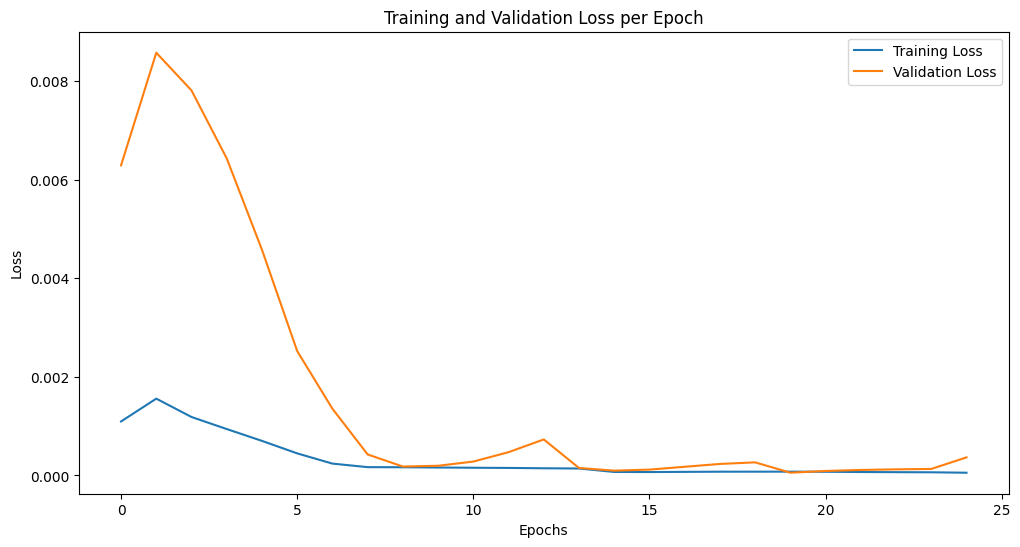

In [ ]:
import matplotlib.pyplot as plt



# Grafico di training e validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




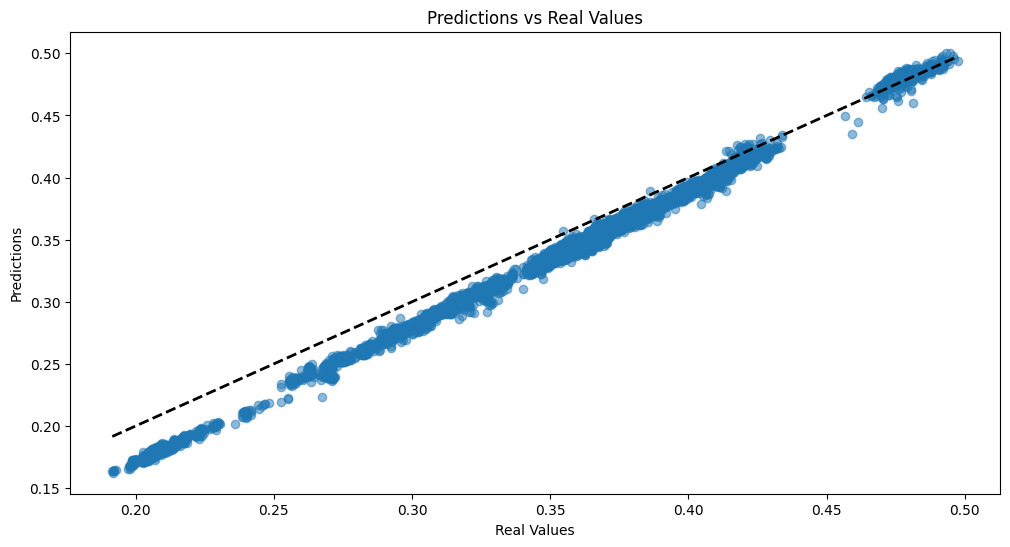

In [ ]:

plt.figure(figsize=(12, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.title('Predictions vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'k--', lw=2)  # Linea y=x per riferimento
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
